<a href="https://colab.research.google.com/github/pedroafleite/crypto-risk-assessment/blob/main/prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install quandl

In [38]:
import quandl as qd
import pandas as pd
import numpy as np
import datetime
import fbprophet
import matplotlib.pyplot as plt


import plotly.offline as py
import plotly.graph_objs as go
import warnings
warnings.simplefilter("ignore")
py.init_notebook_mode()

In [39]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

# **Bitcoin**

In [40]:
KEY = "zykxDXyzgxQSoKZM6y6v"
qd.ApiConfig.api_key = KEY
bitcoin = qd.get("BCHAIN/MKPRU")
bitcoin = bitcoin.loc[(bitcoin !=0).any(1)]

In [41]:
bitcoin = bitcoin.reset_index()
bitcoin.head()

Date   Value
0 2010-08-16  0.0769
1 2010-08-18  0.0688
2 2010-08-19  0.0667
3 2010-08-20  0.0700
4 2010-08-21  0.0664

In [42]:
bitcoin["log_y"] = np.log(bitcoin["Value"])

In [43]:
bitcoin = bitcoin.rename(columns={"Date": "ds", "log_y" : "y"})
bitcoin.head()

ds   Value         y
0 2010-08-16  0.0769 -2.565249
1 2010-08-18  0.0688 -2.676552
2 2010-08-19  0.0667 -2.707550
3 2010-08-20  0.0700 -2.659260
4 2010-08-21  0.0664 -2.712058

In [77]:
priors = [0.0005, 0.005]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior, daily_seasonality=True)
    prophet.fit(bitcoin)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

In [78]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [82]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = f"{priors[0]}_ds", right_on = f"{priors[1]}_ds")
output = output.rename(columns={f"{priors[0]}_ds": "Date"}).drop(f"{priors[1]}_ds", axis=1)

In [83]:
output = output.set_index('Date')
output.head()

trend_x  yhat_lower_x  ...  multiplicative_terms_upper_y    yhat_y
Date                                ...                                        
2011-08-01  2.593157      1.498375  ...                           0.0  1.146627
2011-08-02  2.595395      1.508289  ...                           0.0  1.161688
2011-08-03  2.597633      1.581118  ...                           0.0  1.172325
2011-08-04  2.599870      1.567259  ...                           0.0  1.182487
2011-08-05  2.602108      1.539621  ...                           0.0  1.191422

[5 rows x 42 columns]

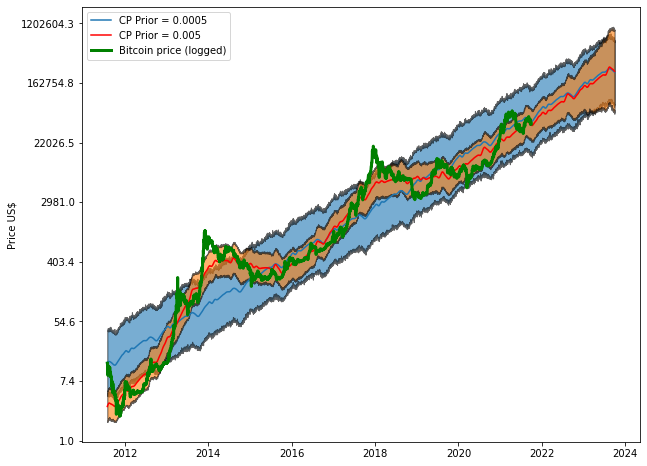

In [84]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(bitcoin.ds, bitcoin.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

In [85]:
output = output.reset_index()
output = output.rename(columns={"Date": "ds", "log_y" : "y"})
btc_prophet = pd.merge(bitcoin, output, how='inner', on='ds', sort=True)
btc_prophet.head()

ds  Value  ...  multiplicative_terms_upper_y    yhat_y
0 2011-08-01  13.45  ...                           0.0  1.146627
1 2011-08-02  13.10  ...                           0.0  1.161688
2 2011-08-03  13.37  ...                           0.0  1.172325
3 2011-08-04  11.55  ...                           0.0  1.182487
4 2011-08-05  11.00  ...                           0.0  1.191422

[5 rows x 48 columns]

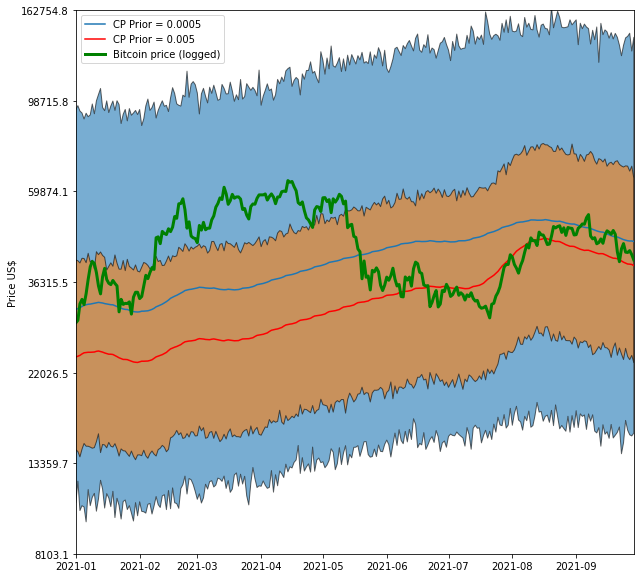

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(btc_prophet.ds, btc_prophet["yhat_x"], label=labels[0])
ax.fill_between(btc_prophet.ds, btc_prophet["yhat_upper_x"], btc_prophet["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(btc_prophet.ds, btc_prophet["yhat_y"], "r", label=labels[1]);
ax.fill_between(btc_prophet.ds, btc_prophet["yhat_upper_y"], btc_prophet["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(btc_prophet.ds, btc_prophet.y, color="green", linewidth=3, label=r"Bitcoin price (logged)")
ax.set_ylim([9,12])
ax.plot(ylim=(15000,160000))
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
ax.set_xlim([datetime.date(2021, 1, 1), datetime.datetime.today().date()])
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

In [51]:
from sklearn.metrics import mean_absolute_error

MAE: 1.102


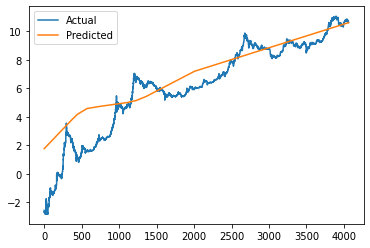

In [52]:
# calculate MAE between expected and predicted values for June
y_true = bitcoin['y'].values
y_pred = output['trend_x'][-bitcoin['y'].shape[0]:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

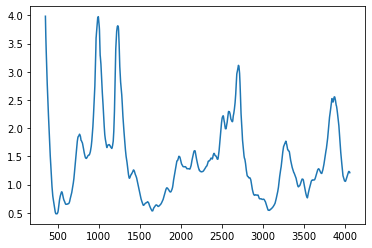

In [53]:
bitcoin['50SMA'] = bitcoin.Value.rolling(window=50).mean()
bitcoin['350SMA'] = bitcoin.Value.rolling(window=350).mean()
bitcoin['R'] = bitcoin['50SMA']/bitcoin['350SMA']
bitcoin = bitcoin.dropna()

bitcoin['R'].plot();

In [62]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(prophet, initial='730 days', period='90 days', horizon = '180 days')
df_cv.head()

INFO:fbprophet:Making 32 forecasts with cutoffs between 2013-08-12 00:00:00 and 2021-04-02 00:00:00


  0%|          | 0/32 [00:00<?, ?it/s]

ds      yhat  yhat_lower  yhat_upper         y     cutoff
0 2013-08-13  4.649366    4.521979    4.776872  4.669459 2013-08-12
1 2013-08-14  4.645340    4.524835    4.774257  4.587821 2013-08-12
2 2013-08-15  4.630400    4.503068    4.745912  4.590158 2013-08-12
3 2013-08-16  4.633030    4.514756    4.763709  4.585783 2013-08-12
4 2013-08-17  4.621770    4.495977    4.742542  4.595322 2013-08-12

In [65]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.tail()

horizon       mse      rmse       mae      mape     mdape  coverage
158 176 days  1.348722  1.161345  0.924541  0.125252  0.110057  0.690972
159 177 days  1.350703  1.162198  0.926402  0.125479  0.111273  0.696181
160 178 days  1.354790  1.163954  0.928843  0.125841  0.112656  0.703125
161 179 days  1.355758  1.164370  0.930439  0.126065  0.113576  0.706597
162 180 days  1.356893  1.164857  0.931785  0.126240  0.115196  0.710069

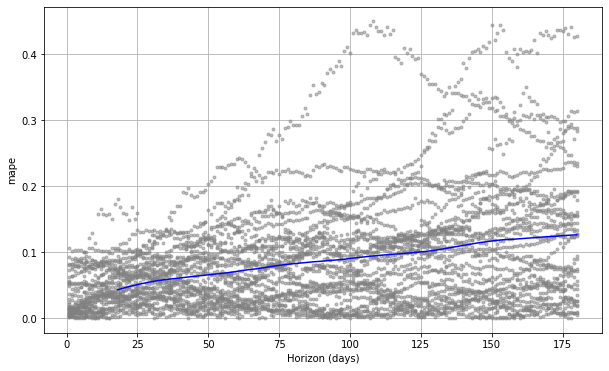

In [67]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [88]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.0005, 0.005, 0.05, 0.5, 2.5],
    'seasonality_prior_scale': [0.005, 0.05, 0.5, 5.0, 50.0],
}

# cutoffs = pd.to_datetime(['2015-06-30', '2017-10-01', '2020-03-01', '2021-02-15'])

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = fbprophet.Prophet(**params).fit(bitcoin)  # Fit model with given params
    df_cv = cross_validation(m, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2014-10-01 00:00:00 and 2020-09-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe949278590>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2014-10-01 00:00:00 and 2020-09-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe9503d0250>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 13 forecasts with cutoffs between 2014-10-01 00:00:00 and 2020-09-29 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fe949272fd0>
INFO:fbprophet:Disabling daily seasonality. Run p

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                    0.0005                    0.005  1.261485
1                    0.0005                    0.050  1.107378
2                    0.0005                    0.500  1.172309
3                    0.0005                    5.000  1.242648
4                    0.0005                   50.000  1.279743
5                    0.0050                    0.005  1.170966
6                    0.0050                    0.050  1.164896
7                    0.0050                    0.500  1.197199
8                    0.0050                    5.000  1.167947
9                    0.0050                   50.000  1.196202
10                   0.0500                    0.005  1.093468
11                   0.0500                    0.050  1.092522
12                   0.0500                    0.500  1.091405
13                   0.0500                    5.000  1.094294
14                   0.0500                   50.000  1

In [89]:
tuning_results.sort_values(by='rmse', ascending=False)

changepoint_prior_scale  seasonality_prior_scale      rmse
4                    0.0005                   50.000  1.279743
0                    0.0005                    0.005  1.261485
3                    0.0005                    5.000  1.242648
22                   2.5000                    0.500  1.235516
7                    0.0050                    0.500  1.197199
9                    0.0050                   50.000  1.196202
24                   2.5000                   50.000  1.185613
2                    0.0005                    0.500  1.172309
5                    0.0050                    0.005  1.170966
8                    0.0050                    5.000  1.167947
17                   0.5000                    0.500  1.166330
23                   2.5000                    5.000  1.165464
6                    0.0050                    0.050  1.164896
16                   0.5000                    0.050  1.154910
18                   0.5000                    5.000  1.150052
21                   2.5000                    0.050  1.143402
19                   0.5000                   50.000  1.123731
15                   0.5000                    0.005  1.114945
20                   2.5000                    0.005  1.114831
1                    0.0005                    0.050  1.107378
13                   0.0500                    5.000  1.094294
10                   0.0500                    0.005  1.093468
11                   0.0500                    0.050  1.092522
14                   0.0500                   50.000  1.092003
12                   0.0500                    0.500  1.091405

In [61]:
df_cv.tail(10)

ds      yhat  yhat_lower  yhat_upper          y     cutoff
5465 2021-09-20  9.753062    6.559221   12.454796  10.763195 2020-09-29
5466 2021-09-21  9.751424    6.539316   12.600809  10.666663 2020-09-29
5467 2021-09-22  9.745369    6.426319   12.412996  10.611998 2020-09-29
5468 2021-09-23  9.738221    6.476512   12.460072  10.682922 2020-09-29
5469 2021-09-24  9.731233    6.457521   12.522827  10.711947 2020-09-29
5470 2021-09-25  9.726193    6.498201   12.532893  10.664657 2020-09-29
5471 2021-09-26  9.721645    6.403900   12.443056  10.662938 2020-09-29
5472 2021-09-27  9.719141    6.374932   12.547894  10.673194 2020-09-29
5473 2021-09-28  9.718366    6.452268   12.625261  10.651080 2020-09-29
5474 2021-09-29  9.713323    6.342517   12.602677  10.621600 2020-09-29

# **Ethereum**

In [18]:
KEY = "zykxDXyzgxQSoKZM6y6v"
qd.ApiConfig.api_key = KEY
eth = qd.get("BITFINEX/ETHUSD")
eth = eth.loc[(eth !=0).any(1)]

In [19]:
eth = eth.reset_index()
eth.head()

Date    High     Low      Mid    Last     Bid     Ask        Volume
0 2016-03-14  14.950  11.400  12.9325  12.925  12.925  12.940  22922.937642
1 2016-03-15  13.421  11.607  12.9665  12.765  12.924  13.009  18157.378517
2 2016-03-16  13.890  12.621  12.8200  12.800  12.800  12.840   5431.139409
3 2016-03-17  12.893  10.436  11.2450  11.368  11.172  11.318  25158.103084
4 2016-03-18  11.200   8.338  10.8155  10.750  10.751  10.880  46391.436185

In [20]:
eth["log_y"] = np.log(eth["Last"])
eth = eth.rename(columns={"Date": "ds", "log_y" : "y"})
eth.head()

ds    High     Low      Mid  ...     Bid     Ask        Volume         y
0 2016-03-14  14.950  11.400  12.9325  ...  12.925  12.940  22922.937642  2.559163
1 2016-03-15  13.421  11.607  12.9665  ...  12.924  13.009  18157.378517  2.546707
2 2016-03-16  13.890  12.621  12.8200  ...  12.800  12.840   5431.139409  2.549445
3 2016-03-17  12.893  10.436  11.2450  ...  11.172  11.318  25158.103084  2.430802
4 2016-03-18  11.200   8.338  10.8155  ...  10.751  10.880  46391.436185  2.374906

[5 rows x 9 columns]

In [21]:
priors = [0.0005, 0.005]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(eth)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

In [23]:
output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0005_ds", right_on = "0.005_ds")
output = output.rename(columns={"0.0005_ds": "Date"}).drop("0.005_ds", axis=1)
output = output.set_index('Date')

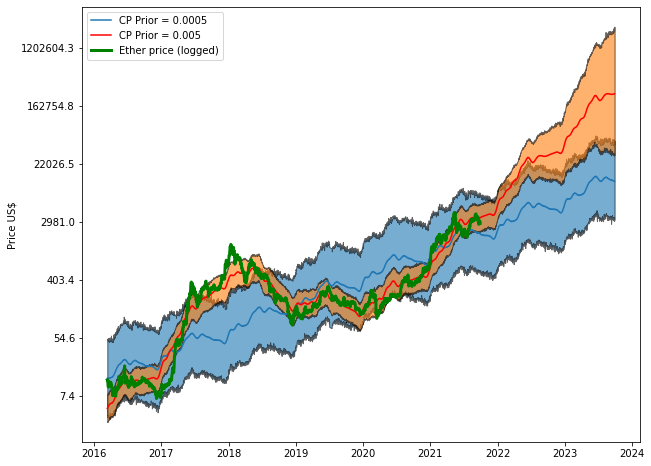

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(eth.ds, eth.y, color="green", linewidth=3, label=r"Ether price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Price US$")
plt.show()

MAE: 1.789


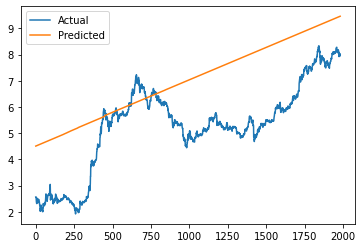

In [25]:
# calculate MAE between expected and predicted values for June
y_true = eth['y'].values
y_pred = output['trend_x'][-eth['y'].shape[0]:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [26]:
output['trend_x'][-(eth['y'].shape[0]):].values

array([4.5058806 , 4.50835   , 4.5108194 , ..., 9.45946762, 9.46193701,
       9.46440639])

In [27]:
output['trend_x'].values

array([2.66370822, 2.66617762, 2.66864702, ..., 9.45946762, 9.46193701,
       9.46440639])

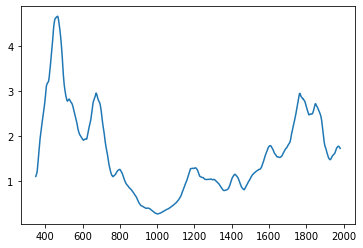

In [28]:
eth['50SMA'] = eth.Last.rolling(window=50).mean()
eth['350SMA'] = eth.Last.rolling(window=350).mean()
eth['R'] = eth['50SMA']/eth['350SMA']
eth = eth.dropna()

eth['R'].plot();

# **ETH/BTC**

In [29]:
KEY = "zykxDXyzgxQSoKZM6y6v"
qd.ApiConfig.api_key = KEY
ethbtc = qd.get("BITFINEX/ETHBTC")
ethbtc = ethbtc.loc[(ethbtc !=0).any(1)]

In [30]:
ethbtc = ethbtc.reset_index()
ethbtc.head()

Date      High       Low  ...       Bid       Ask         Volume
0 2016-03-14  0.050580  0.028241  ...  0.031102  0.031260  111142.045174
1 2016-03-15  0.032004  0.027950  ...  0.031207  0.031390   62965.262239
2 2016-03-16  0.033500  0.030465  ...  0.030690  0.030709   55947.825399
3 2016-03-17  0.030989  0.024759  ...  0.026821  0.026935   94445.983815
4 2016-03-18  0.026960  0.020150  ...  0.026506  0.026605  141106.891752

[5 rows x 8 columns]

In [31]:
ethbtc["log_y"] = np.log(ethbtc["Last"])
ethbtc = ethbtc.rename(columns={"Date": "ds", "log_y" : "y"})
ethbtc.head()

ds      High       Low  ...       Ask         Volume         y
0 2016-03-14  0.050580  0.028241  ...  0.031260  111142.045174 -3.470451
1 2016-03-15  0.032004  0.027950  ...  0.031390   62965.262239 -3.460979
2 2016-03-16  0.033500  0.030465  ...  0.030709   55947.825399 -3.483818
3 2016-03-17  0.030989  0.024759  ...  0.026935   94445.983815 -3.618757
4 2016-03-18  0.026960  0.020150  ...  0.026605  141106.891752 -3.630271

[5 rows x 9 columns]

In [32]:
priors = [0.0015, 0.015]
prophets, labels = [], []
for prior in priors:
    prophet = fbprophet.Prophet(changepoint_prior_scale=prior)
    prophet.fit(ethbtc)
 
    prophets.append(prophet)
    labels.append(r"CP Prior = " + str(prior))

forecasts = []
for prophet in prophets:
    forecast = prophet.make_future_dataframe(periods=365 * 2, freq="D")
    forecast = prophet.predict(forecast)
 
    forecast = forecast.rename(columns={"ds" : str(priors[prophets.index(prophet)]) + "_ds"})
    forecasts.append(forecast)

output = pd.merge(forecasts[0], forecasts[1], how = "inner", left_on = "0.0015_ds", right_on = "0.015_ds")
output = output.rename(columns={"0.0015_ds": "Date"}).drop("0.015_ds", axis=1)
output = output.set_index('Date')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


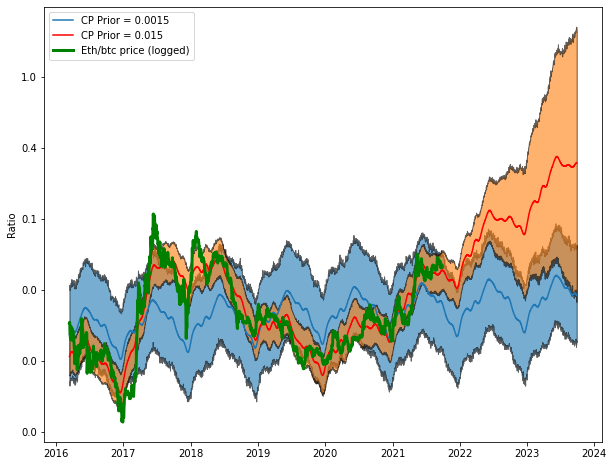

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(output.index, output["yhat_x"], label=labels[0])
ax.fill_between(output.index, output["yhat_upper_x"], output["yhat_lower_x"], alpha=0.6, edgecolor = "k")
ax.plot(output.index, output["yhat_y"], "r", label=labels[1]);
ax.fill_between(output.index, output["yhat_upper_y"], output["yhat_lower_y"], alpha=0.6, edgecolor = "k")
ax.plot(ethbtc.ds, ethbtc.y, color="green", linewidth=3, label=r"Eth/btc price (logged)")
a=ax.get_yticks().tolist()
ax.set_yticklabels(np.round(np.exp(a), 1))
plt.legend(loc="upper left")
plt.ylabel(r"Ratio")
plt.show()

MAE: 0.498


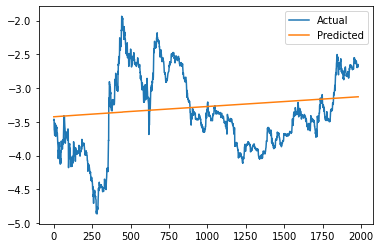

In [34]:
# calculate MAE between expected and predicted values for June
y_true = ethbtc['y'].values
y_pred = output['trend_x'][-ethbtc['y'].shape[0]:].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

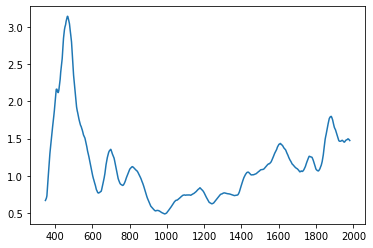

In [35]:
ethbtc['50SMA'] = ethbtc.Last.rolling(window=50).mean()
ethbtc['350SMA'] = ethbtc.Last.rolling(window=350).mean()
ethbtc['R'] = ethbtc['50SMA']/ethbtc['350SMA']
ethbtc = ethbtc.dropna()

ethbtc['R'].plot();